In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ast
import copy

In [21]:
to_discard = list(map(str, pd.read_excel('data/discard2.xlsx', header=None, names=['id'])['id'].tolist()))
print(to_discard)

['1d96', '1e8f', '02a8', '2c4f', '2f8b', '2fe0', '04b4', '4dbe', '4fa2', '5f87', '7af7', '7c64', '8a11', '8f91', '18fe', '44ce', '52c9', '60b1', '79bf', '3bf8', '3c5e', '3d25', '3e8e', '4a48', '4ac3', '4d58', '5c80', '5d47', '6bf2', '6c1f', '7e11', '8b7d', '017b', '37af', '37c5', '055f', '57eb', '81c6', '87a3', '88e3', '88e2', '89c1', '93a1', '96f2', '208a', '279d', '287b', '334b', '511d', '629b', '716c', '832f', '4579', '4604', '5639', '5683', '3693', '4153', '6441', '7761', '3828', 'a03e', 'ab90', 'ab47', 'abbf', 'ad30', 'b641', 'bd77', 'be39', 'ff73', 'c7b6', 'c617', 'c828', 'ca17', 'cfe3', 'd3a5', 'd3ee', 'd4dd', 'd5ae', 'd4f9', 'd5ed', 'd6ad', 'd6be', 'd6f2', 'd8a2', 'd8dd', 'd8ee', 'fbb0', 'd8ff', 'd9fe', 'd044', 'd44d', 'd49a', 'd52e', 'd59e', 'd68d', 'd69d', 'd76f', 'd78a', 'd80b', 'd81c', 'd82d', 'd83d', 'fb59', 'd549', 'd659', 'd725', 'd859', 'd986', 'd452', 'd648', 'd110', 'd583', 'd615', 'da27', 'da96', 'dab0', 'dacc', 'f350', 'fb1e', 'daf7', 'db4d', 'db6a', 'db16', 'db32',

In [22]:
train = pd.read_csv('data/train.csv', converters={'frame_of_reference_UID': ast.literal_eval, 'image_hash': ast.literal_eval, 'image_uuid': ast.literal_eval})
test = pd.read_csv('data/test.csv', converters={'frame_of_reference_UID': ast.literal_eval, 'image_hash': ast.literal_eval, 'image_uuid': ast.literal_eval})

In [24]:
train_drop, test_drop = [], []
train_oct, test_oct = [], []
not_found = copy.deepcopy(to_discard)

for id in to_discard:
    for i in range(len(train)):
        if train['image_uuid'][i]['fundus'].startswith(id):
            train_drop.append(i)
            train_oct.append(train['image_uuid'][i]['horizontal'])
            not_found.remove(id)
            break
    for i in range(len(test)):
        if test['image_uuid'][i]['fundus'].startswith(id):
            test_drop.append(i)
            test_oct.append(test['image_uuid'][i]['horizontal'])
            not_found.remove(id)
            break

for id in train_oct:
    for i in range(len(train)):
        if train['image_uuid'][i]['horizontal'].startswith(id):
            train_drop.append(i)
            break
for id in test_oct:
    for i in range(len(test)):
        if test['image_uuid'][i]['horizontal'].startswith(id):
            test_drop.append(i)
            break

train_new = train.drop(train_drop)
test_new = test.drop(test_drop)

print(f'Removed {len(train_drop)} images from train set')
print(f'Removed {len(test_drop)} images from test set')
print(f'Could not find {len(not_found)} images:')
print(not_found)

Removed 216 images from train set
Removed 46 images from test set
Could not find 4 images:
['52c9', '629b', '5639', 'd452']


In [48]:
path = 'data'
train_new.to_csv(f'{path}/train_noscars.csv', index=False)
test_new.to_csv(f'{path}/test_noscars.csv', index=False)

In [27]:
keys = ['l_npdr', 'r_npdr', 'l_pdr', 'r_pdr']
train_dist = {key: 0 for key in keys}
test_dist = {key: 0 for key in keys}

for _, item in train_new.iterrows():
    lat = item['laterality'].lower()
    prl = item['proliferation'].lower()
    train_dist[f'{lat}_{prl}'] += 1

for _, item in test_new.iterrows():
    lat = item['laterality'].lower()
    prl = item['proliferation'].lower()
    test_dist[f'{lat}_{prl}'] += 1

data_dist = {key: train_dist[key] + test_dist[key] for key in keys}

In [29]:
print(f'Train distribution: {train_dist}')
print(f'Test distribution: {test_dist}')
print(f'Total distribution: {data_dist}')

Train distribution: {'l_npdr': 182, 'r_npdr': 308, 'l_pdr': 41, 'r_pdr': 65}
Test distribution: {'l_npdr': 42, 'r_npdr': 76, 'l_pdr': 14, 'r_pdr': 12}
Total distribution: {'l_npdr': 224, 'r_npdr': 384, 'l_pdr': 55, 'r_pdr': 77}


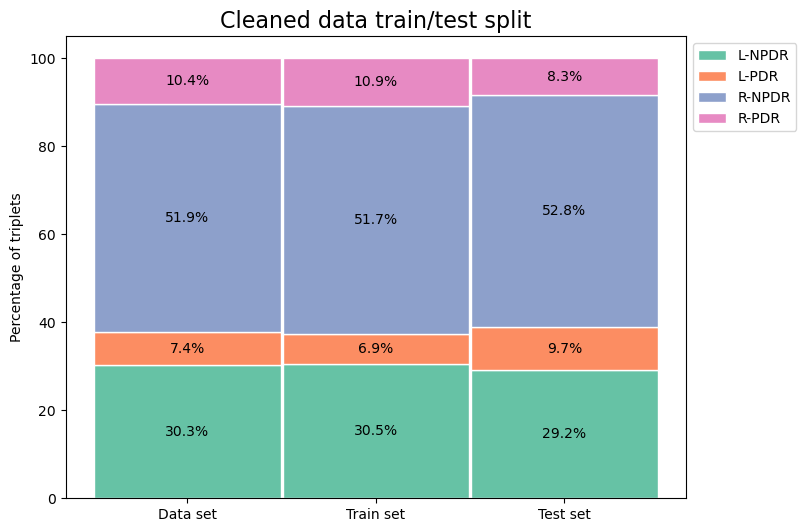

In [44]:
my_cmap = [plt.cm.get_cmap('Set2')(i) for i in range(4)]

# Stacked bar plot
fig1 = plt.figure(figsize=(8,6))
plt.title('Cleaned data train/test split', fontsize=16)
dists = [data_dist, train_dist, test_dist]
titles = ['Data set', 'Train set', 'Test set']

x_axis = np.arange(len(titles))
bars = {k: [d[k]/sum(d.values())*100 for d in dists] for k in keys}

plt.bar(x_axis, bars['l_npdr'], label='L-NPDR', color=my_cmap[0], width=0.99, edgecolor='w')
plt.bar(x_axis, bars['l_pdr'], bottom=bars['l_npdr'], label='L-PDR', color=my_cmap[1], width=0.99, edgecolor='w')
plt.bar(x_axis, bars['r_npdr'], bottom=[i+j for i, j in zip(bars['l_npdr'], bars['l_pdr'])], label='R-NPDR', color=my_cmap[2], width=0.99, edgecolor='w')
plt.bar(x_axis, bars['r_pdr'], bottom=[i+j+k for i, j, k in zip(bars['l_npdr'], bars['l_pdr'], bars['r_npdr'])], label='R-PDR', color=my_cmap[3], width=0.99, edgecolor='w')
for c in plt.gca().containers:
    plt.bar_label(c, fmt='%.1f%%', label_type='center')
plt.xticks(x_axis, titles)
plt.ylabel('Percentage of triplets')
plt.legend(bbox_to_anchor=(1., 1), loc='upper left')
plt.show()

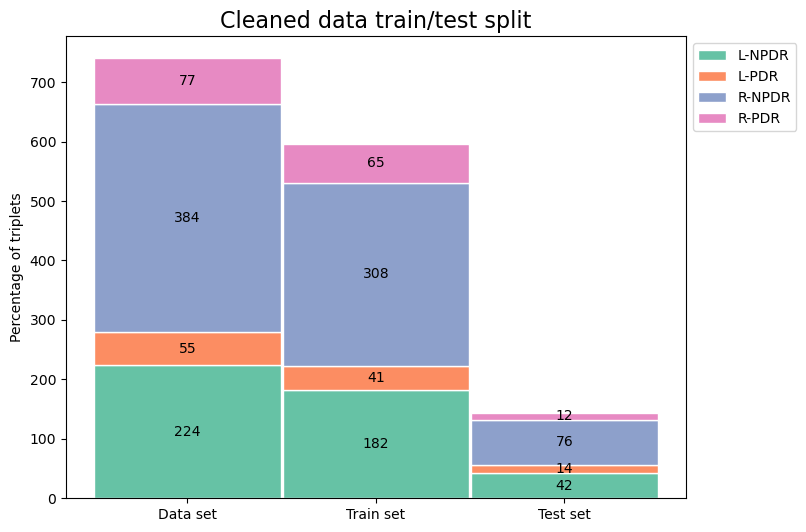

In [46]:
# Stacked bar plot
fig2 = plt.figure(figsize=(8,6))
plt.title('Cleaned data train/test split', fontsize=16)
dists = [data_dist, train_dist, test_dist]
titles = ['Data set', 'Train set', 'Test set']

x_axis = np.arange(len(titles))
bars = {k: [d[k] for d in dists] for k in keys}

plt.bar(x_axis, bars['l_npdr'], label='L-NPDR', color=my_cmap[0], width=0.99, edgecolor='w')
plt.bar(x_axis, bars['l_pdr'], bottom=bars['l_npdr'], label='L-PDR', color=my_cmap[1], width=0.99, edgecolor='w')
plt.bar(x_axis, bars['r_npdr'], bottom=[i+j for i, j in zip(bars['l_npdr'], bars['l_pdr'])], label='R-NPDR', color=my_cmap[2], width=0.99, edgecolor='w')
plt.bar(x_axis, bars['r_pdr'], bottom=[i+j+k for i, j, k in zip(bars['l_npdr'], bars['l_pdr'], bars['r_npdr'])], label='R-PDR', color=my_cmap[3], width=0.99, edgecolor='w')
for c in plt.gca().containers:
    plt.bar_label(c, label_type='center')
plt.xticks(x_axis, titles)
plt.ylabel('Percentage of triplets')
plt.legend(bbox_to_anchor=(1., 1), loc='upper left')
plt.show()

In [47]:
fig1.savefig('plots/split_distribution_noscars_percentage.png', bbox_inches='tight', dpi=300)
fig2.savefig('plots/split_distribution_noscars_numbers.png', bbox_inches='tight', dpi=300)